In [6]:
from pathlib import Path
import os
import glob
import numpy as np
import tifffile
import pandas as pd
from skimage.transform import resize
from scipy.ndimage import binary_fill_holes
from utils import get_gpu_details, list_images, read_image, plot_segmentation

get_gpu_details()

Device name: /device:GPU:0
Device type: GPU
GPU model: device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
# Copy the path where your images are stored, you can use absolute or relative paths to point at other disk locations
directory_path = Path("./raw_data/nihanseb_organoid")

# Image size reduction (downsampling) to improve processing times (slicing, not lossless compression)
# Now, in addition to xy, you can downsample across your z-stack
slicing_factor_xy = 4 # Use 2 or 4 for downsampling in xy (None for lossless)
slicing_factor_z = None # Use 2 to select 1 out of every 2 z-slices

# Define the nuclei and markers of interest channel order ('Remember in Python one starts counting from zero')
nuclei_channel = 2

# Fill holes inside the resulting organoid mask? Set to False if you want to keep the holes
fill_holes = True

# Analyze intensity within the 3D volume of the ROI, or perform a mean or max intensity projection of the marker channel (2D)
analysis_type = "2D" #"2D" or "3D" "2D" recommended

# If 2D analysis type, Choose projection type (mean intensity or max intensity)
# Mean intensity projection would be the equivalent of analyzing avg_intensity within the 3D volume
projection_type = "mean" # "mean" or "max" "mean" recommended

# Stardist model name if nuclei labels predictions are present
model_name = None

# Iterate through the .czi and .nd2 files in the raw_data directory
images = list_images(directory_path)

images

['raw_data\\nihanseb_organoid\\MLD 1.8 block4 ARSA MBP batch 1 40x.nd2',
 'raw_data\\nihanseb_organoid\\MLD 2.2 block7 MBP MAP2 slide 7 batch 2 40x.nd2']

In [8]:
# Define the channels you want to analyze using the following structure:
# markers = [(channel_name, channel_nr, min_max_range),(..., ...)]
# Remember in Python one starts counting from 0, so your first channel will be 0
# min_max range defines the pixel intensity range within which a cell is considered positive for a marker
# i.e. markers = [("ARSA", 0, (0, 65536)), ("MBP", 1, (0, 65536))]
markers = [("ARSA", 0, (110, 1000)), ("MBP", 1, (110, 65536))]

'results\nihanseb_organoid\perc_pos' folder already exists.


Image analyzed: MLD 1.8 block4 ARSA MBP batch 1 40x
Original Array shape: (3, 24, 10797, 10797)
Compressed Array shape: (3, 24, 2700, 2700)

Analyzing ROI: organoid_sf4
Extracting % of ROI + for ARSA inside 2D_organoid_sf4
Percentage of ROI occupied by ARSA marker: 31.66%
Extracting % of ROI + for MBP inside 2D_organoid_sf4
Percentage of ROI occupied by MBP marker: 32.59%


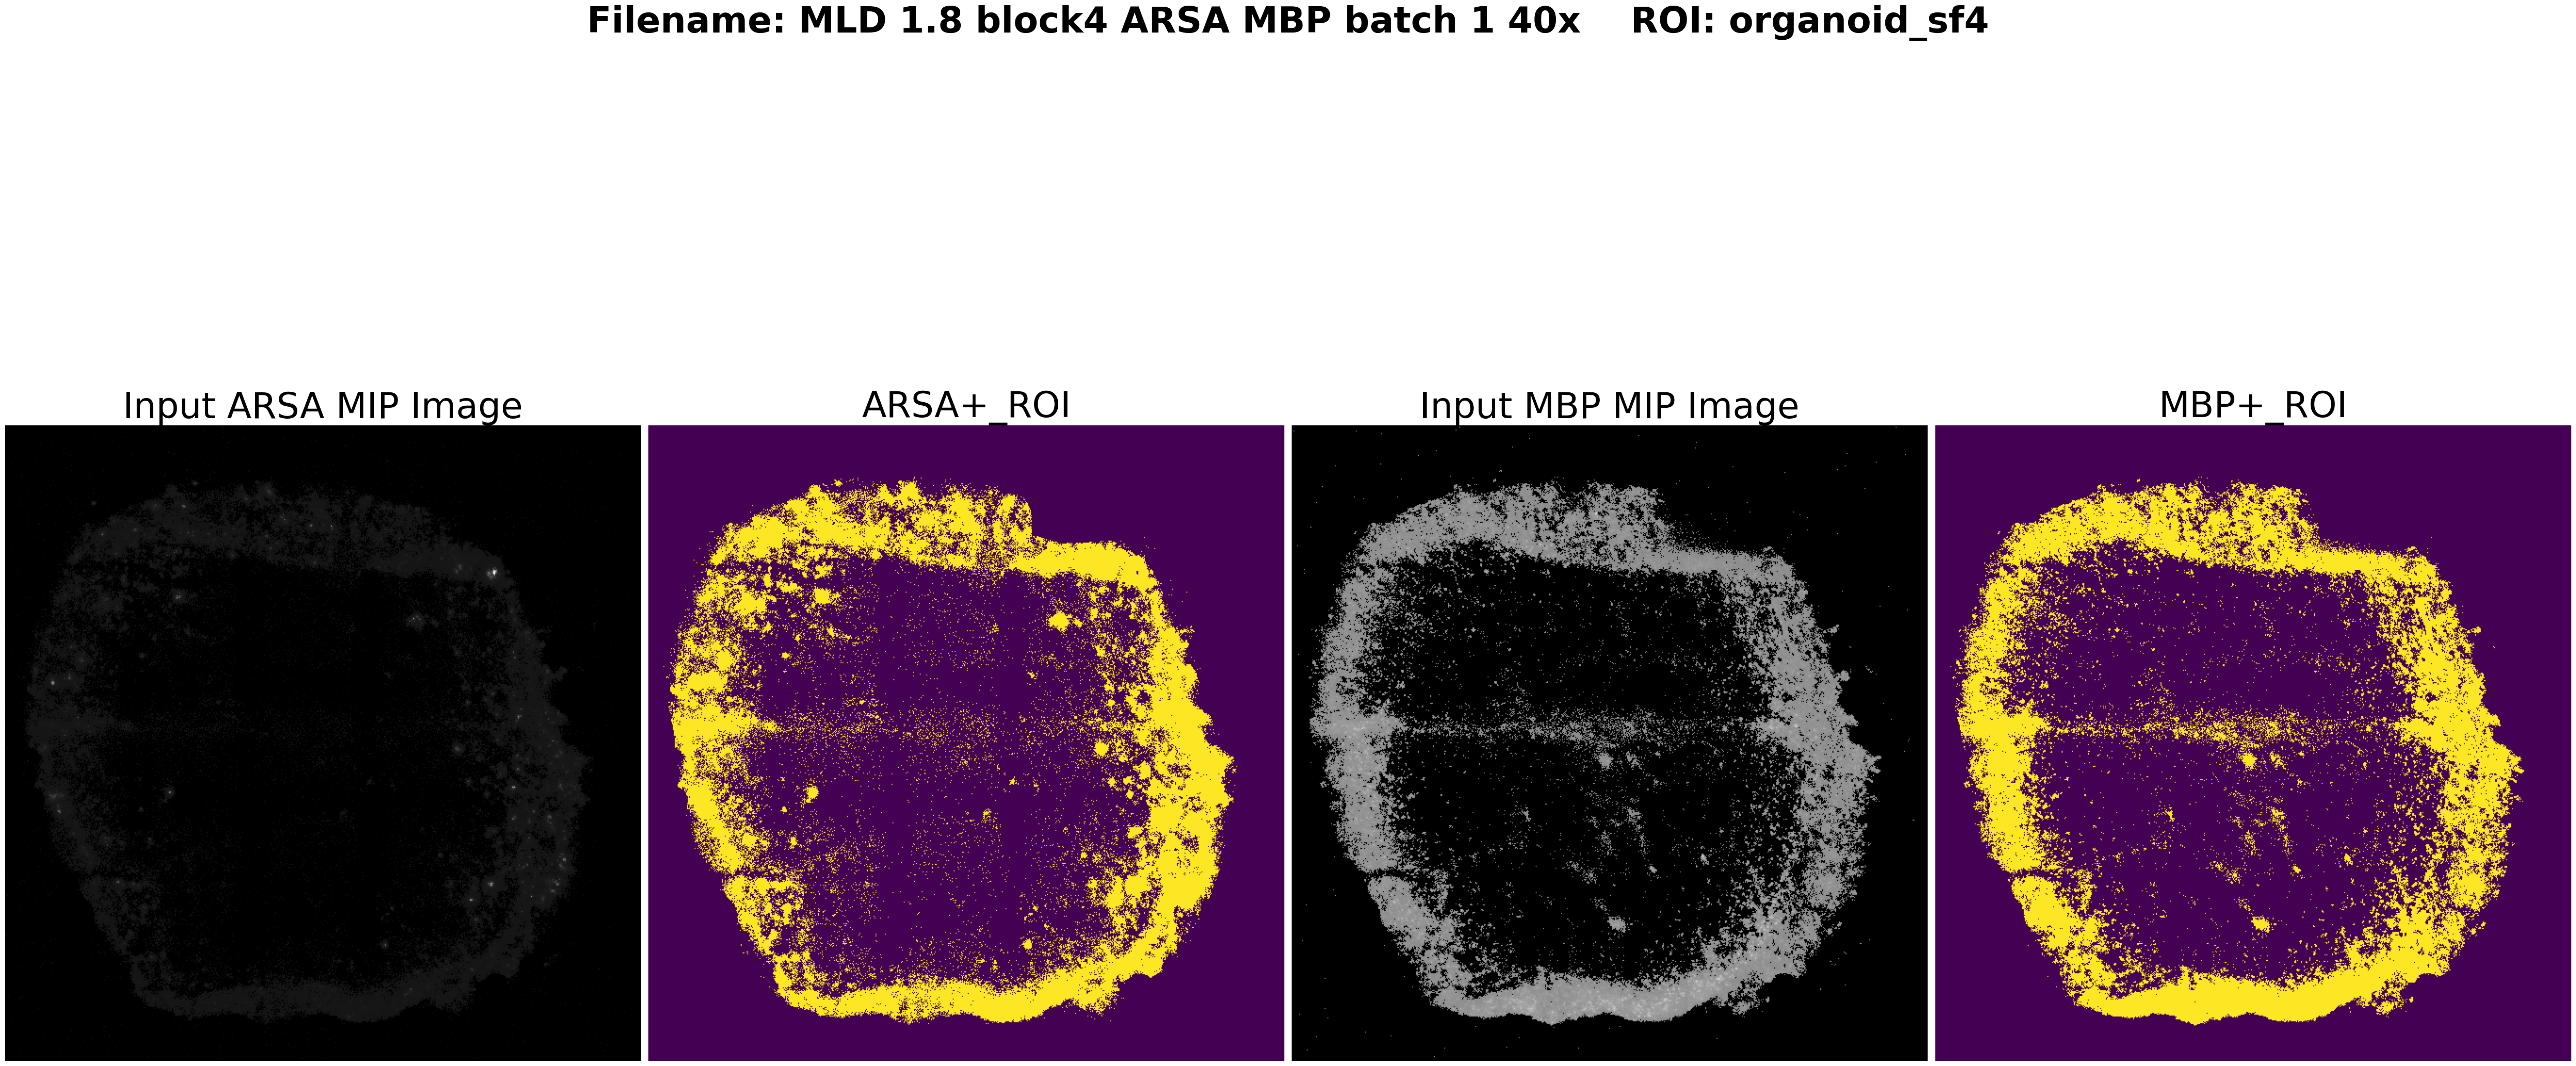



Image analyzed: MLD 2.2 block7 MBP MAP2 slide 7 batch 2 40x
Original Array shape: (3, 24, 10191, 12603)
Compressed Array shape: (3, 24, 2548, 3151)

Analyzing ROI: organoid_sf4
Extracting % of ROI + for ARSA inside 2D_organoid_sf4
Percentage of ROI occupied by ARSA marker: 54.76%
Extracting % of ROI + for MBP inside 2D_organoid_sf4
Percentage of ROI occupied by MBP marker: 3.41%


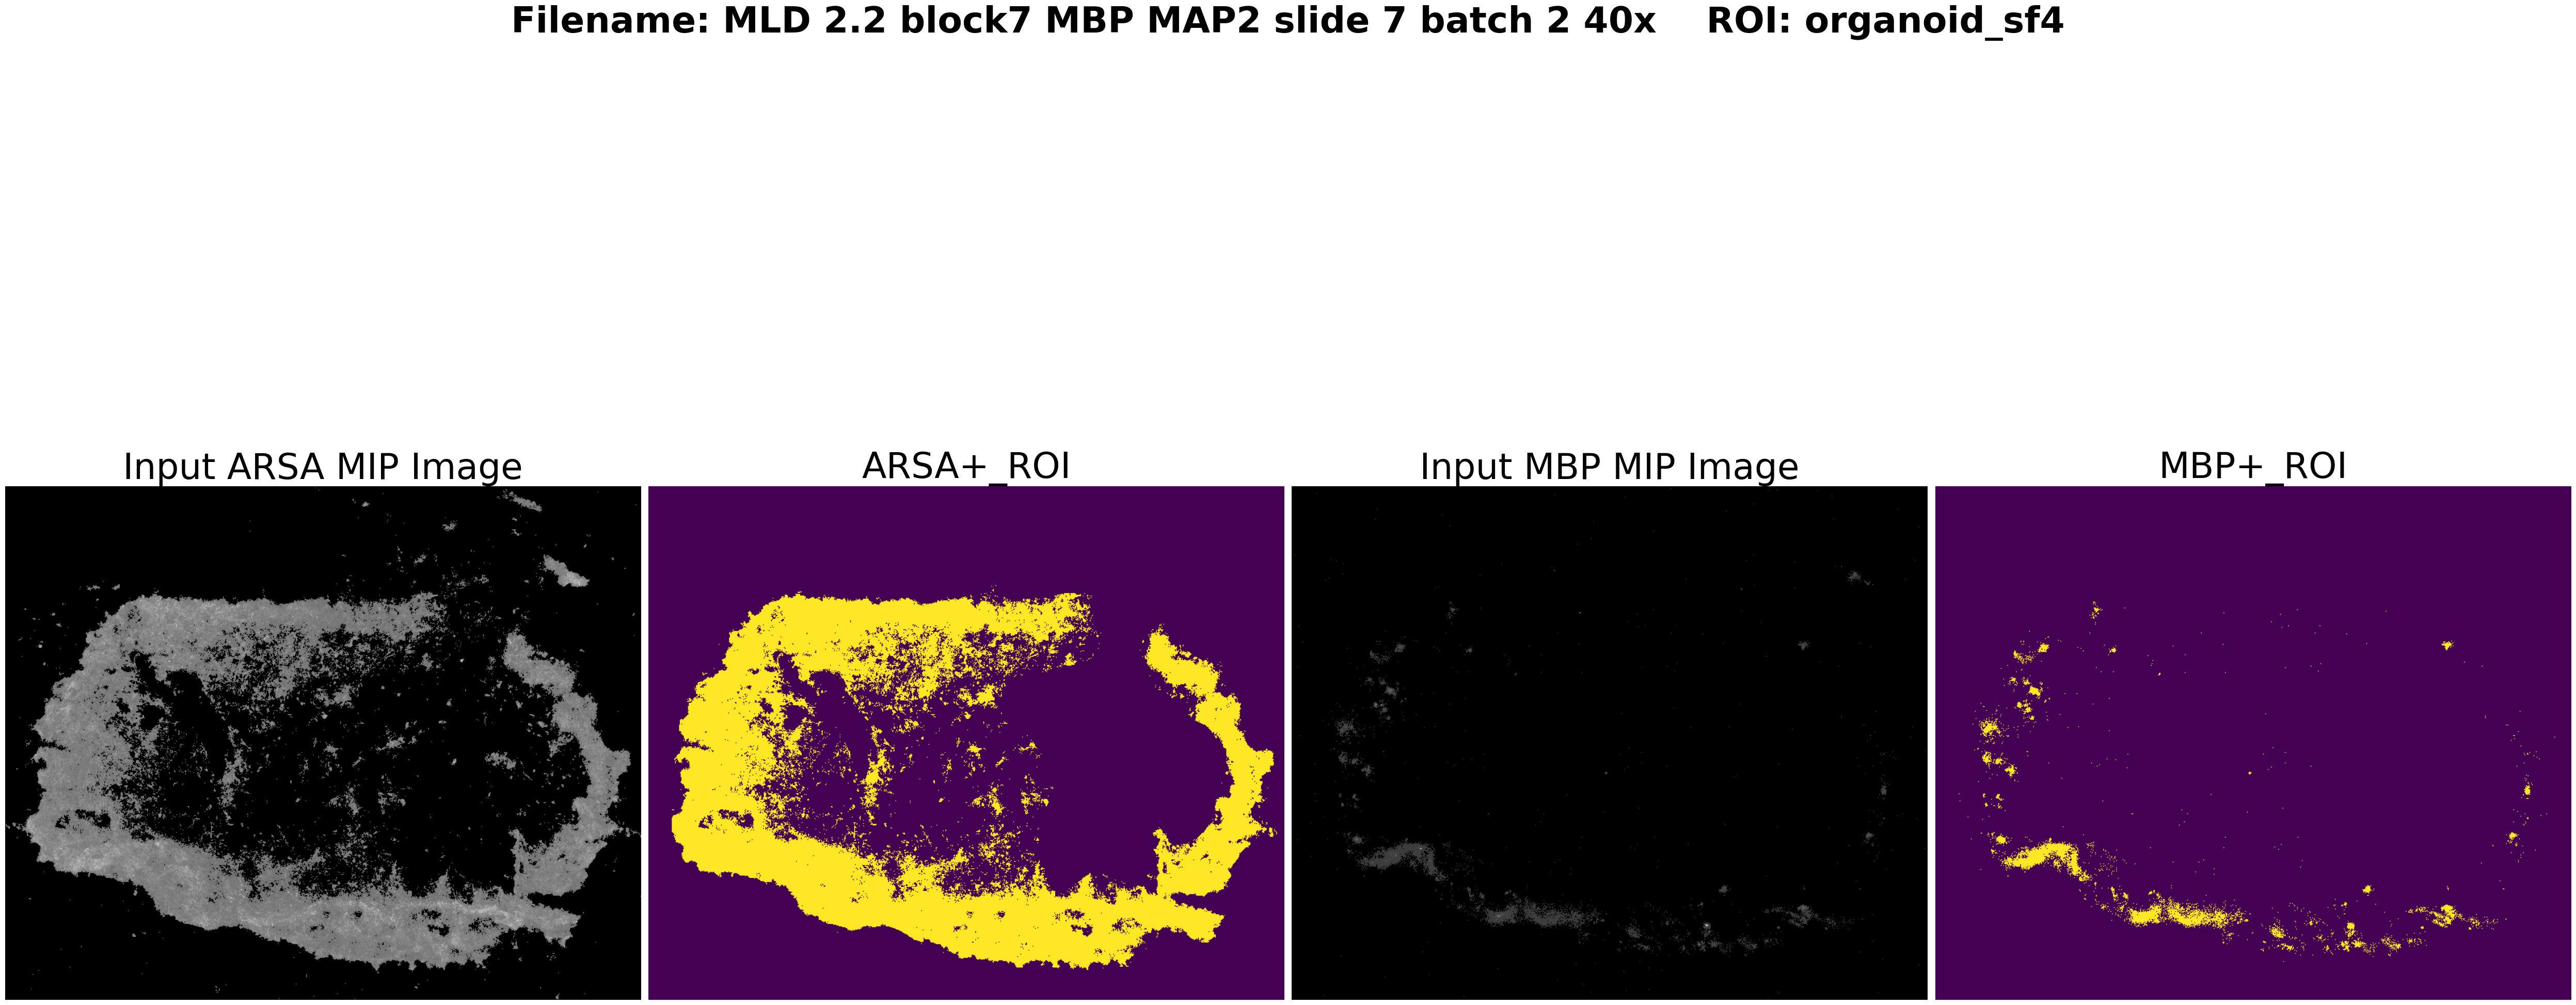

All CSV files concatenated and saved to results\nihanseb_organoid\perc_pos\BP_per_filename_summary.csv


In [9]:
# Construct ROI and nuclei predictions paths from directory_path above
roi_path = directory_path / "ROIs"
# nuclei_preds_path =  directory_path / "nuclei_preds" / analysis_type / model_name

# Extract the experiment name from the data directory path
experiment_id = directory_path.name

# Check for presence of ROIs
try:
    roi_names = [folder.name for folder in roi_path.iterdir() if folder.is_dir()]

except FileNotFoundError:
    roi_names = ["auto_generated_ROI"]
    print("No manually defined ROI found, generating ROI automatically...")

# Create a 'results' folder in the root directory to store results
results_folder = Path("results") / experiment_id / "perc_pos"

try:
    os.makedirs(results_folder)
    print(f"'{results_folder}' folder created successfully.")
except FileExistsError:
    print(f"'{results_folder}' folder already exists.")

# Loop through all images in the directory
for image in images:

    # Read image, apply slicing if needed and return filename and img as a np array
    img, filename = read_image(image, slicing_factor_xy, slicing_factor_z)

    # 3D logic
    if analysis_type == "3D":
        # Set projection_type variable to None
        projection_type = None

    # Generate maximum or mean intensity projection
    if projection_type == "max":
        img_projection = np.max(img, axis=1)
    elif projection_type == "mean":
        img_projection = np.mean(img, axis=1)

    # Initialize an empty list to hold the extracted dataframes on a per roi basis
    props_list = []

    # Initialize an empty list to store channel names and downsampled images on a per roi basis
    plots = []

    for roi_name in roi_names:

        print(f"\nAnalyzing ROI: {roi_name}")

        # Initialize a dictionary to store data needed by matplotlib
        plot = {
                "filename": filename,
                "roi": roi_name,
                "markers":[]
                }

        # Read the user defined ROIs, in case of missing ROI implement logic for automatic segmentation
        try:
            # Read previously defined ROIs
            organoid_mask = tifffile.imread(roi_path / roi_name / f"{filename}.tiff")

        except FileNotFoundError:
            # Add logic to automatically generate an organoid mask
            pass

        # Resample the organoid ROI if input img and ROI shape differ
        if organoid_mask.shape[-2:] != img.shape[-2:]:
            roi_slicing_factor = organoid_mask.shape[-1] / img.shape[-1]
            
            if roi_slicing_factor > 1:
                print("Slicing ROI to match input image shape")
                roi_slicing_factor = round(organoid_mask.shape[-1] / img.shape[-1])
                organoid_mask = organoid_mask[::round(roi_slicing_factor), ::round(roi_slicing_factor)]
        
            elif roi_slicing_factor < 1:
                print("Upsampling ROI to match input image shape")
                organoid_mask = resize(
                    organoid_mask, img.shape[-2:], order=0, preserve_range=True, anti_aliasing=False
                )

        # Update plot dict with ROI mask (including 3D analysis type)
        plot["roi_mask"] = organoid_mask[::4, ::4]
        
        # If analysis type == "3D" extend ROI over the entire volume
        if analysis_type == "3D":
            # Extract the number of z-slices to extend the mask
            slice_nr = img.shape[1]
            # Extend the mask across the entire volume
            organoid_mask = np.tile(organoid_mask, (slice_nr, 1, 1))

        if fill_holes:
            # Close empty holes surrounded by True pixels
            organoid_mask = binary_fill_holes(organoid_mask)

        # Transform organoid mask into a label type without the need to perform connected components
        organoid_mask = organoid_mask.astype(np.uint8)

        # Create a dictionary containing all image descriptors
        descriptor_dict = {
                    "filename": filename,
                    "roi": roi_name,
                    "fill_holes": fill_holes,
                    "slicing_factor_xy": slicing_factor_xy,
                    "analysis_type": analysis_type,
                    "projection_type": projection_type,
                    }

        for channel_name, ch_nr, min_max_range in markers:

            print(f"Extracting % of ROI + for {channel_name} inside {analysis_type}_{roi_name}")

            if analysis_type == "2D":
                # Ignore pixel values below the min_range (set them to 0)
                img_projection[ch_nr] = np.where(img_projection[ch_nr] > min_max_range[0], img_projection[ch_nr], 0)

                # Ignore pixels whose value is equal or above the max_range
                # ROI is modified to ignore said pixels (results in filtered organoid_mask)

                filtered_organoid_mask = np.where(img_projection[ch_nr] <= min_max_range[1], organoid_mask, 0)

                # Obtain ROI occupied by pixels positive for a marker within min_max_range
                roi_positive_for_marker = (img_projection[ch_nr] > 0) & (filtered_organoid_mask > 0)

                # Update dictionary with data for matplotlib to plot
                plot["markers"].append((channel_name, img_projection[ch_nr, ::4, ::4], roi_positive_for_marker[::4, ::4])) 
                
            elif analysis_type == "3D":
                # Ignore pixel values below the min_range (set them to 0)
                img[ch_nr] = np.where(img[ch_nr] > min_max_range[0], img[ch_nr], 0)

                # Ignore pixels whose value is equal or above the max_range
                # ROI is modified to ignore said pixels (results in filtered organoid_mask)

                filtered_organoid_mask = np.where(img[ch_nr] <= min_max_range[1], organoid_mask, 0)

                # Obtain ROI occupied by pixels positive for a marker within min_max_range
                roi_positive_for_marker = (img[ch_nr]) > 0 & (filtered_organoid_mask > 0)

                # Update dictionary with data for matplotlib to plot (3D --> 2D)
                plot["markers"].append((channel_name, np.max(img[ch_nr], axis=0)[::4, ::4], np.max(roi_positive_for_marker, axis=0)[::4, ::4]))

            # Extract area information from filtered_organoid and roi_positive_for_marker
            # Compute the number of nonzero pixels
            total_filtered_area = np.count_nonzero(filtered_organoid_mask)
            total_positive_area = np.count_nonzero(roi_positive_for_marker)

            # Calculate the percentage
            percent_positive = (total_positive_area / total_filtered_area) * 100 if total_filtered_area > 0 else 0

            # Save extracted data in the descriptor_dictionary
            descriptor_dict[f"filtered_ROI_area_{channel_name}"] = total_filtered_area
            descriptor_dict[f"+_area_{channel_name}"] = total_positive_area
            descriptor_dict[f"+_area_{channel_name}"] = percent_positive

            print(f"Percentage of ROI occupied by {channel_name} marker: {percent_positive:.2f}%")
                
        # Convert to dataframe
        props_df = pd.DataFrame([descriptor_dict])

        # Add dataframe to ROI props list
        props_list.append(props_df)

        # Add updated plot dictionary to list 
        plots.append(plot)

        # Define the .csv path
        csv_path = results_folder / f'{filename}_perc_pos.csv'

        # Concatenate into a single DataFrame
        final_df = pd.concat(props_list, ignore_index=True) 

        # Save to .csv
        final_df.to_csv(csv_path)

    # Plot resulting segmentations on a per_ROI basis
    plot_segmentation(plots)

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(results_folder, "*.csv"))

# Read and concatenate all CSV files
all_dataframes = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(all_dataframes, ignore_index=True)

# Save the concatenated DataFrame to a new CSV file
output_path = os.path.join(results_folder, "BP_per_filename_summary.csv")
combined_df.to_csv(output_path, index=False)

print(f"All CSV files concatenated and saved to {output_path}")